<a href="https://colab.research.google.com/github/adowd444/MSG_NLP/blob/main/MSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import multiprocessing
from sklearn.metrics import accuracy_score, f1_score
! pip install testfixtures
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

     |████████████████████████████████| 95 kB 3.4 MB/s 


In [ ]:
df = pd.read_csv('corp.csv')
df.head()

,Unnamed: 0,text,label
0,0,holcomb vetoes bill would given indiana legisl...,local politics
1,1,transmission lines wind turbines kansas city m...,community matters
2,2,text middletown ohio fox19 man accused disposi...,crime
3,3,generally cloudy high 31f winds nnw 10 15 mph ...,crime
4,4,mix clouds sun early followed cloudy skies aft...,community matters


In [ ]:
df.shape

(1849, 3)

In [ ]:
#get total words in all text
df.index = range(1849)
df['text'].apply(lambda x: len(x.split(' '))).sum()

733885

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


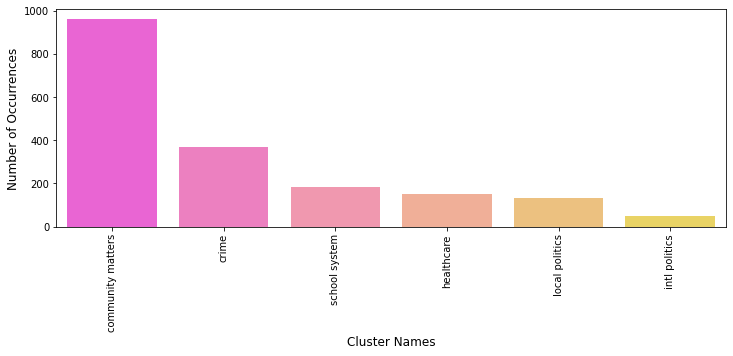

In [ ]:
cnt_pro = df['label'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8, palette='spring')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Cluster Names', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['text'] = df['text'].apply(cleanText)

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
nltk.download('punkt')

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_tagged.values[30]

TaggedDocument(words=['young', 'teens', 'able', 'follow', 'older', 'siblings', 'footsteps', 'vaccinated', 'indiana', 'adolescents', 'ages', '12', '15', 'able', 'make', 'appointment', 'vaccination', 'soon', 'thursday', 'centers', 'disease', 'control', 'prevention', 'federal', 'committee', 'issued', 'favorable', 'recommendation', 'indiana', 'department', 'health', 'posted', 'notice', 'vaccine', 'website', 'signup', 'process', 'awaiting', 'federal', 'agency', 'final', 'joseph', 'county', 'mark', 'fo', 'deputy', 'health', 'officer', 'said', 'heard', 'adolescents', 'getting', 'vaccines', 'wednesday', 'means', 'state', 'site', 'register', 'able', 'register', 'children', 'ample', 'amount', 'vaccine', 'available', 'vaccination', 'cvs', 'also', 'said', 'wednesday', 'afternoon', 'new', 'vaccination', 'group', 'could', 'register', 'shots', 'indiana', 'cvs', 'new', 'vaccine', 'group', 'adds', 'county', 'numbers', 'approaching', 'herd', 'immunity', 'fo', 'said', 'new', 'vaccination', 'ages', 'go', 

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
#distributed bag of words model
odel_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 1294/1294 [00:00<00:00, 1668438.17it/s]


In [ ]:
%%time
for epoch in range(10):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 1294/1294 [00:00<00:00, 2317433.55it/s]


CPU times: user 9.64 s, sys: 122 ms, total: 9.76 s
Wall time: 5.36 s


In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.8954954954954955
Testing F1 score: 0.8952047873840258


In [ ]:
#distributed memory model
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 1294/1294 [00:00<00:00, 952013.57it/s]


In [ ]:
%%time
for epoch in range(10):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 1294/1294 [00:00<00:00, 1624492.48it/s]


CPU times: user 16.1 s, sys: 419 ms, total: 16.6 s
Wall time: 9.31 s


In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.8324324324324325
Testing F1 score: 0.83260912028664


In [ ]:
#distributed memory using concatenated doc2vec
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [ ]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [ ]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing Accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 Score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.836036036036036
Testing F1 score: 0.8363857635464658
